In [11]:
import numpy as np
import matplotlib.pyplot as plt
from utils import uniform_shell_sampler, make_nice_plots
from scipy import stats
from tqdm import tqdm

make_nice_plots()


In [2]:
def dVdr_prior(rcom, rmax):
    '''Uniform in volume distribution on radius, normalized between 0 and rmax.'''
    return rcom**2 / rmax**3 * 3


In [24]:
RMIN = 0
RMAX = 100
NAGN = int(1e4)
NGW_ALT = int(5e2)
NGW_AGN = int(5e2)
N_MC_SAMPS = int(1e4)
GW_RCOM_ERR = 0.01
rr = np.linspace(RMIN, RMAX, 1000)

In [25]:
agn_pos, _, _ = uniform_shell_sampler(RMIN, RMAX, NAGN)

In [26]:
true_gw_alt_pos, _, _ = uniform_shell_sampler(RMIN, RMAX, NGW_ALT)
true_gw_agn_pos = np.random.choice(agn_pos, NGW_AGN)

obs_gw_alt_pos = np.random.normal(loc=true_gw_alt_pos, scale=GW_RCOM_ERR)
obs_gw_agn_pos = np.random.normal(loc=true_gw_agn_pos, scale=GW_RCOM_ERR)

p_agn_alt_gws = np.zeros(NGW_ALT)
p_agn_agn_gws = np.zeros(NGW_AGN)
p_alt_alt_gws = np.zeros(NGW_ALT)
p_alt_agn_gws = np.zeros(NGW_AGN)
chunk = 100
for i in tqdm(range(int(NGW_AGN / chunk))):
    start, stop = int(i * chunk), int((i + 1) * chunk)

    posterior_alt_gws = lambda x: stats.norm.pdf(x, loc=obs_gw_alt_pos[start:stop], scale=GW_RCOM_ERR)
    posterior_agn_gws = lambda x: stats.norm.pdf(x, loc=obs_gw_agn_pos[start:stop], scale=GW_RCOM_ERR)

    p_agn_alt_gws[start:stop] = np.sum( posterior_alt_gws(agn_pos[:,np.newaxis]), axis=0 ) / NAGN
    p_agn_agn_gws[start:stop] = np.sum( posterior_agn_gws(agn_pos[:,np.newaxis]), axis=0 ) / NAGN

    p_alt_alt_gws[start:stop] = np.sum( dVdr_prior( np.random.normal(loc=true_gw_alt_pos[start:stop], scale=GW_RCOM_ERR, size=(N_MC_SAMPS, chunk)), 
                                    RMAX ), axis=0) / N_MC_SAMPS
    p_alt_agn_gws[start:stop] = np.sum( dVdr_prior( np.random.normal(loc=true_gw_agn_pos[start:stop], scale=GW_RCOM_ERR, size=(N_MC_SAMPS, chunk)), 
                                    RMAX ), axis=0) / N_MC_SAMPS


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


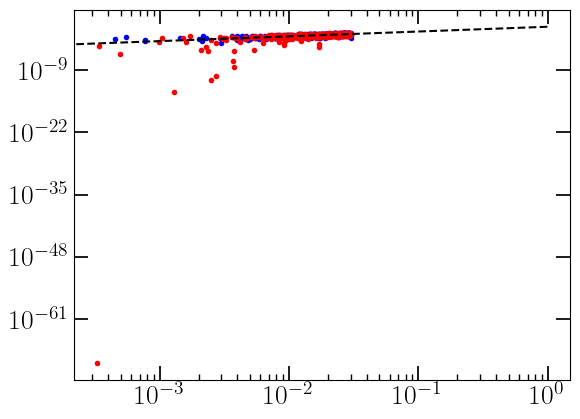

In [27]:
# plt.figure()
# plt.hist(agn_pos, bins=30, density=True)
# plt.plot(rr, dVdr_prior(rr, RMAX))
# plt.plot(rr, posterior_alt_gws(rr[:,np.newaxis])[:,0])
# plt.show()

plt.figure()
plt.scatter(p_alt_agn_gws, p_agn_agn_gws, color='blue', marker='.')
plt.scatter(p_alt_alt_gws, p_agn_alt_gws, color='red', marker='.')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='black', linestyle='dashed')
plt.loglog()
plt.show()


In [28]:
# Some translations to reuse my code
cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
palt = cw_palt  # c = 1
agn_events = np.ones(int(NGW_AGN + NGW_ALT), dtype=bool)
agn_events[NGW_AGN:] = 0
alt_events = ~agn_events


100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


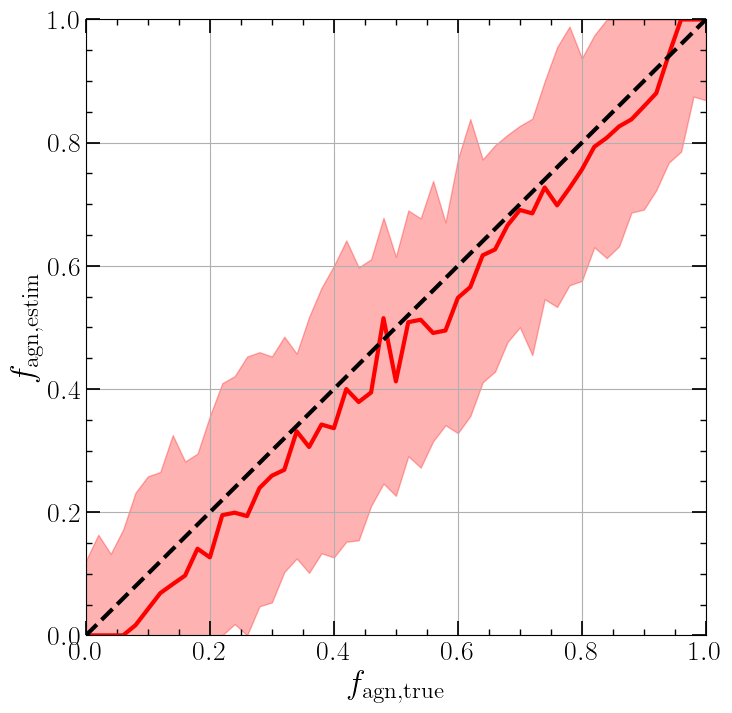

In [29]:
use_N_gws = 100
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
n_trials = 100
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn

if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )  

    log_llh_denominator = 0  # TODO: GW selection effects
    log_llh = log_llh_numerator - log_llh_denominator
    # max_log_llh = np.max(log_llh, axis=0)
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)

# CI = np.linspace(0, 1, 1001)
# for ci, alpha in zip([0.68, 0.95, 0.997], [0.1, 0.15, 0.2]):
#     edge_of_bound = (1. - ci) / 2.
#     lower = binom.ppf(1 - edge_of_bound, use_N_gws, CI) / use_N_gws
#     upper = binom.ppf(edge_of_bound, use_N_gws, CI) / use_N_gws
#     lower[0] = 0
#     upper[0] = 0
#     plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
# plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
